Starting model training with arecanut.csv data...
Epoch 1/100


c:\Users\shett\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0175 - val_loss: 0.0039
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0


Training complete. A new, accurate 'model.h5' has been saved.
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


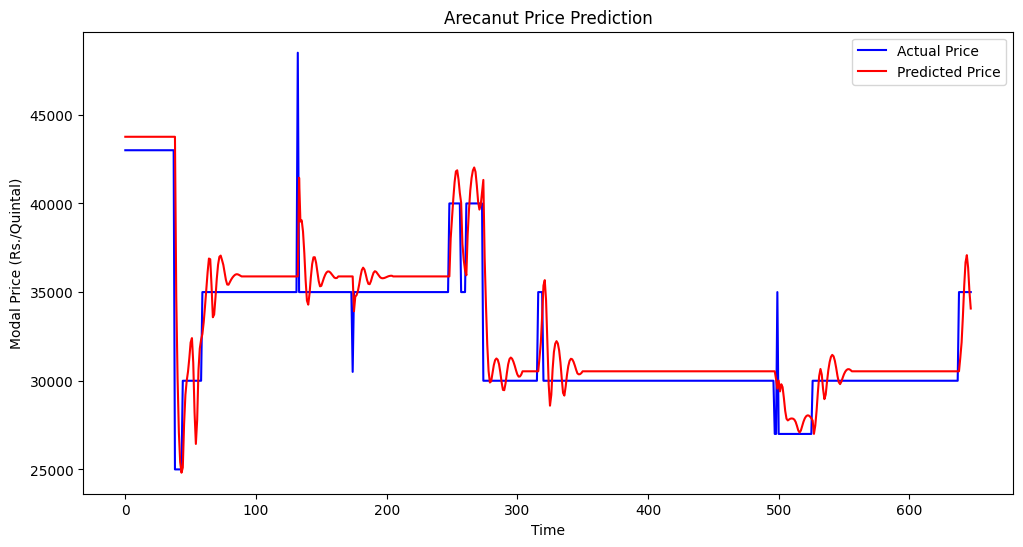

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- 1. Load and Prepare the Data ---
try:
    df = pd.read_csv("arecanut.csv")
    df['Price Date'] = pd.to_datetime(df['Price Date'])
    df = df.sort_values('Price Date') # Sort data chronologically
    
    # We will predict the 'Modal Price (Rs./Quintal)'
    price_data = df[['Modal Price (Rs./Quintal)']].values
    
except FileNotFoundError:
    print("Error: 'arecanut.csv' not found.")
    exit()

# --- 2. Scale the Data ---
# LSTMs work best with data scaled between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# --- 3. Create Time-Series Sequences ---
# We'll use the last 30 days of data to predict the next day's price
X_data = []
y_data = []
time_step = 30

for i in range(time_step, len(scaled_data)):
    X_data.append(scaled_data[i-time_step:i, 0])
    y_data.append(scaled_data[i, 0])

X_data, y_data = np.array(X_data), np.array(y_data)

# Reshape the data for the LSTM model: [samples, time_steps, features]
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))

# --- 4. Split Data Chronologically ---
# Use the first 80% of the data for training, the rest for testing
training_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[0:training_size], X_data[training_size:len(X_data)]
y_train, y_test = y_data[0:training_size], y_data[training_size:len(y_data)]

# --- 5. Build and Train the New LSTM Model ---
model = Sequential()
# Using a stacked LSTM architecture for better performance
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

print("Starting model training with arecanut.csv data...")
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# --- 6. Save the Newly Trained Model ---
model.save('model.h5')
print("\nTraining complete. A new, accurate 'model.h5' has been saved.")

# --- 7. (Optional) Visualize Predictions ---
# Make predictions on the test set
predictions_scaled = model.predict(X_test)
# Inverse transform the predictions to get the actual price values
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Arecanut Price Prediction')
plt.xlabel('Time')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.legend()
plt.show() 